In [1]:
from tests import generate_dataframe

In [3]:
df = generate_dataframe()
display(df)

Feature 3  ...  Bool feature
Feature 0 Feature 1 Feature 2             ...              
3         4         2                  4  ...          True
          2         4                  1  ...          True
1         4         3                  0  ...          True
2         3         3                  0  ...          True
3         0         3                  1  ...          True
...                                  ...  ...           ...
          2         3                  4  ...          True
          1         1                  4  ...          True
          4         4                  4  ...          True
2         3         3                  1  ...          True
1         2         3                  1  ...          True

[100 rows x 10 columns]

In [29]:
import matplotlib.pyplot as plt
from functools import reduce
from typing import List
import pandas as pd

In [19]:
df.index.levels

FrozenList([[0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4]])

In [20]:
tdf = df[["Feature 3"]]

In [66]:
height = 5
bar_width = 1
increase = 2

In [153]:
def histogram_width(indices: List[int], bar_width : float, increase : float) -> float:
    total_width = bar_width * indices[-1]
    for i, indices_len in enumerate(indices[:-1]):
        total_width = total_width * indices_len + (indices_len - 1) * (bar_width * (increase**(i+1)))
    return total_width

In [170]:
def bar_offset(bar_index: int, indices: List[int], bar_width: float, increase: float) -> float:
    x = bar_index * bar_width
    previous_bars = 1
    for j, index in enumerate(reversed(indices)):
        previous_bars *= index
        if bar_index >= previous_bars:
            x += (bar_index // previous_bars) * bar_width * (increase)
    return x

In [171]:
indices = [2,2,3]#[len(x) for x in df.index.levels]

In [172]:
width = histogram_width(indices, bar_width, increase)
width

20

In [173]:
prod = reduce(lambda x,y: x*y, indices)-1
prod

11

In [177]:
bar_offset(prod, indices, bar_width, increase)

19

In [178]:
x = list(range(25))
for i in range(12):
    j = bar_offset(i,[2,2,3],1,2)
    print(f"{i}\t{j}")
    x[j] = "#"
print(x)

0	0
1	1
2	2
3	5
4	6
5	7
6	12
7	13
8	14
9	17
10	18
11	19
['#', '#', '#', 3, 4, '#', '#', '#', 8, 9, 10, 11, '#', '#', '#', 15, 16, '#', '#', '#', 20, 21, 22, 23, 24]


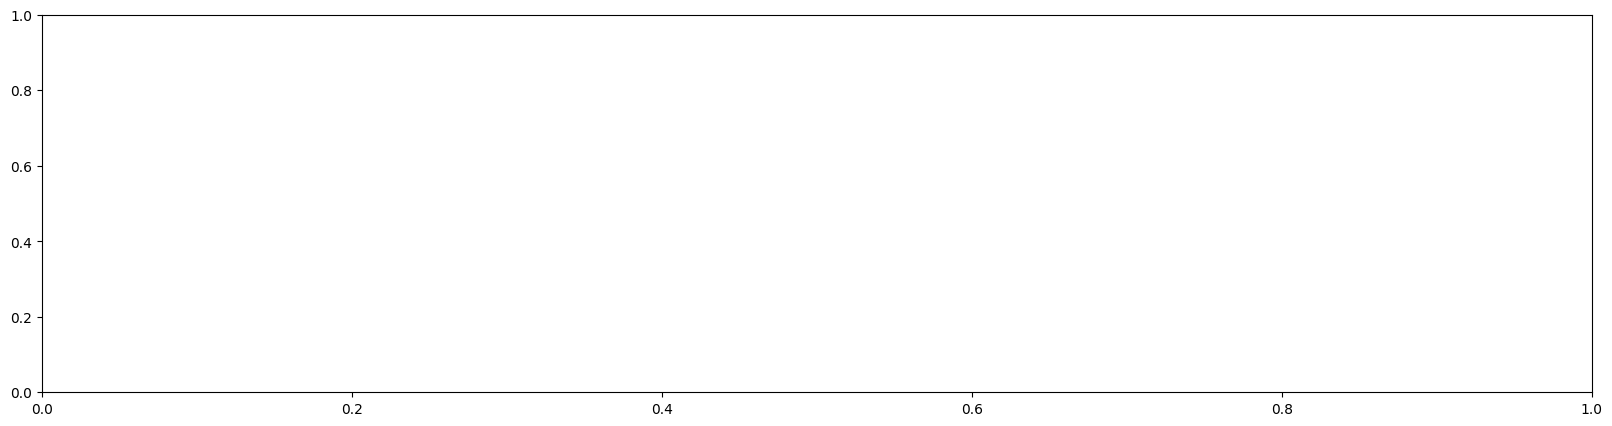

In [160]:
fig, ax = plt.subplots(figsize=(width, height), dpi=100)
